In [1]:
import sys

sys.path.append('../src')
from lda import GibbsLDA
from sim import POLYGONS, make_dataset
from slda import GibbsSLDA
from util import map_labels, show_dataset

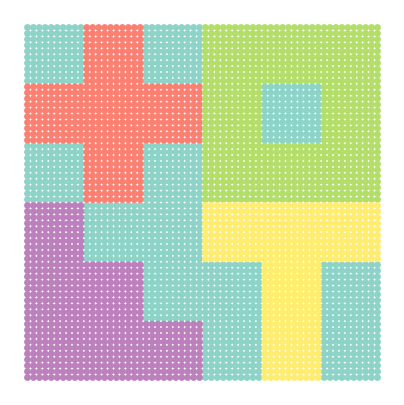

In [2]:
data, labels = make_dataset()
show_dataset(data, labels)

### Latent Dirichlet Allocation

LDA: 100%|██████████| 200/200 [00:10<00:00, 19.86it/s]


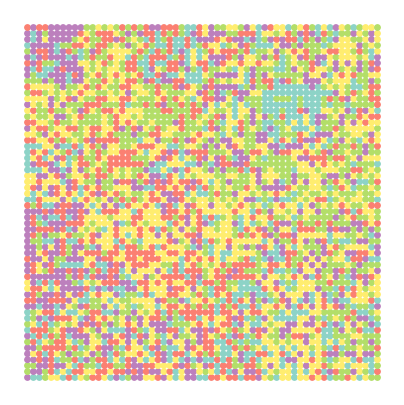

In [3]:
model = GibbsLDA()
topics = map_labels(labels, model.fit_predict(data))
show_dataset(data, topics)

### Spatial Latent Dirichlet Allocation

SLDA: 100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


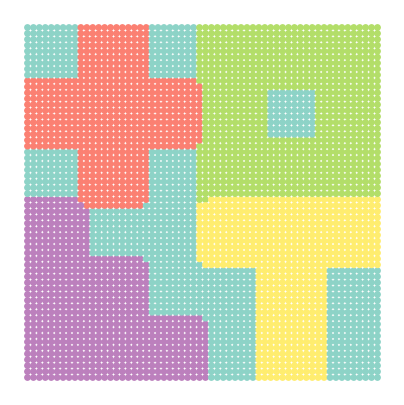

In [4]:
model = GibbsSLDA(word_scale=.4)
topics = map_labels(labels, model.fit_predict(data))
show_dataset(data, topics)